# Popularity Analysis

In [7]:
from google.cloud import bigquery
import pandas_gbq
%load_ext google.cloud.bigquery

# Set your default project here
pandas_gbq.context.project = 'snappy-boulder-378707'
pandas_gbq.context.dialect = 'standard'

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import math
pd.set_option('display.max_columns', 500)

## Preprocessing and feature extraction
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
import datetime as dt
from sklearn.preprocessing import FunctionTransformer

## Models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from xgboost import XGBRegressor

## Model selection and fine tuning
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import statsmodels.api as sm


# for model export
import joblib

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../BigQuery/letsgo-snappy-boulder-378707-4b7d46801fd1.json"

# Construct a BigQuery client object.
client = bigquery.Client()

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


# Import data

## Audio features

In [11]:
%%bigquery audio_feature
SELECT * FROM snappy-boulder-378707.AudioFeatures.AudioFeatures

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
audio_feature.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'id', 'duration_ms', 'time_signature'],
      dtype='object')

In [4]:
audio_feature

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature
0,0.315,0.102,0,-17.621,0,0.0340,0.98500,0.051200,0.1090,0.1850,169.690,0Oqxt6JixieLHbwMfnJGWO,206723,3
1,0.556,0.729,0,-5.907,0,0.0432,0.03310,0.015200,0.0907,0.1520,90.003,2LRqm962By8aNwJX0WxFNG,245204,4
2,0.440,0.497,1,-6.440,0,0.0402,0.09170,0.000000,0.2150,0.2090,73.541,6bBNc3V3PduYNL22lbed5R,156892,4
3,0.648,0.874,1,-3.788,0,0.0545,0.00481,0.000023,0.0471,0.9350,138.007,14qLydrp6Uxy2kzfmv73TZ,222231,4
4,0.400,0.471,1,-12.394,0,0.1610,0.88800,0.048000,0.1150,0.0385,84.481,5ZSqX1dDJ823Dndw94nogY,67804,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74924,0.756,0.913,11,-3.486,0,0.0523,0.23400,0.000000,0.0431,0.8690,110.955,7g9UMHzfI9w8StnZLVh8jV,196253,4
74925,0.881,0.696,11,-3.838,0,0.0797,0.13700,0.000041,0.0927,0.7810,97.002,3mQ6SLdxxaL52Yte7KF2Ks,200667,4
74926,0.881,0.361,11,-14.728,0,0.2370,0.05020,0.004580,0.2460,0.7990,96.430,4HfxDJ0uLHTLe0fZrx0MbQ,216693,4
74927,0.881,0.441,11,-6.278,0,0.0646,0.48000,0.000009,0.1190,0.8040,138.014,5wfllwdjglyQislkskYLBv,221240,4


## Tracks info

In [12]:
%%bigquery track_info
SELECT * FROM snappy-boulder-378707.TrackClearInfo.TrackClearInfo
WHERE popularity <> 0 and available_markets <> 0

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
track_info.head()

,id,name,album_id,artist_id,popularity,explicit,available_markets,extract_date
0,38tKvVe3iURKRFm5X50zLZ,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,69,0,181,2023-03-24
1,32IMgcVhysYW12NRvMLp8c,Want It All (feat. Evalyn),22MkBC5l2Zi9atm66fE0Jq,24V5UY0nChKpnb1TBPJhCw;68WwJXWrpo1yVOOIZjLSeT,30,0,182,2023-03-24
2,4XhdM1Ku9JM4abVuRWAsgk,Dum Dum,4sNLO2KeOADZykYBkqclN1,5xq3BK55BJmutN0X7eTyQB,59,0,183,2023-03-24
3,6McBFhOohQvx0zWkoISnap,Dum Dum - English Version,4sNLO2KeOADZykYBkqclN1,5xq3BK55BJmutN0X7eTyQB,57,0,183,2023-03-24
4,7fEI29hmaWcCMPi8VJf33C,Us Without Me,7rQcfmaOYzHKmAlyeuwdTt,73BLwSX6gsNeVzS7DgI4xe,49,0,184,2023-03-24


## Album info

In [13]:
%%bigquery release_date
SELECT id,release_date FROM snappy-boulder-378707.TrackClearInfo.AlbumInfo

Query is running:   0%|          |

Downloading:   0%|          |

In [8]:
release_date

,id,release_date
0,4XAi7fxJkMgdqS73Wjte5J,2023-03-24
1,4fU1IAiidcbKjProAZuoLF,2023-03-17
2,22MkBC5l2Zi9atm66fE0Jq,2023-03-22
3,7t2qYxQeNwbMVdc5wwaSNa,2023-03-24
4,6qbsZIWMMfIdwCqtpo1G3m,2023-03-24
...,...,...
74935,2fMGewLRioOoYUCgZocVHS,2008-01-01
74936,6ScYJCZCqiclKWdERP8stI,2021-01-16
74937,6ScYJCZCqiclKWdERP8stI,2021-01-16
74938,0RsNQJd8Em0kBK5BDTdAkb,2020-08-31


## Artist_info

In [14]:
%%bigquery artist_info
SELECT distinct id, followers, popularity FROM `snappy-boulder-378707.TrackClearInfo.ArtistInfo`

Query is running:   0%|          |

Downloading:   0%|          |

In [10]:
artist_info

,track_id,followers,popularity
0,2O2zG6idWEIoP59PrXiW6x,378.0,0.0
1,6FH3Ke3VufsFkez4sCNufW,622.0,0.0
2,4rZwRt0nwriL2mvlnyeIlh,494.0,1.0
3,2MuNPjvtdsIIX46Felbx82,41.0,2.0
4,1Cli0gQaSe0NVWEHAyOBIH,15835.0,2.0
...,...,...,...
12864,5IssEtH38Bs8vpGOoVnLlh,891371.0,71.0
12865,5qDs46EokLqDHpQ7sqcHWE,2492123.0,71.0
12866,7qyUlaAYXEEpTsVPUrdQut,1344989.0,71.0
12867,5rz37f8yrSWGR1arwxq9Kb,714934.0,71.0


## Merge data

In [15]:
df = pd.merge(audio_feature, track_info, on="id", how="inner")
del df['extract_date']

In [20]:
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,name,album_id,artist_id,popularity,explicit,available_markets
0,0.619,0.437,4,-7.623,0,0.0244,0.4490,0.001840,0.2920,0.536,90.972,4XhdM1Ku9JM4abVuRWAsgk,195164,4,Dum Dum,4sNLO2KeOADZykYBkqclN1,5xq3BK55BJmutN0X7eTyQB,59,0,183
1,0.613,0.443,4,-7.502,0,0.0247,0.3490,0.000000,0.2370,0.604,91.044,6McBFhOohQvx0zWkoISnap,195164,4,Dum Dum - English Version,4sNLO2KeOADZykYBkqclN1,5xq3BK55BJmutN0X7eTyQB,57,0,183
2,0.674,0.742,0,-6.374,1,0.0384,0.0117,0.000003,0.2810,0.604,135.007,32IMgcVhysYW12NRvMLp8c,186000,4,Want It All (feat. Evalyn),22MkBC5l2Zi9atm66fE0Jq,24V5UY0nChKpnb1TBPJhCw;68WwJXWrpo1yVOOIZjLSeT,30,0,182
3,0.602,0.493,5,-5.695,1,0.0443,0.8250,0.000000,0.3640,0.281,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,69,0,181
4,0.602,0.493,5,-5.695,1,0.0443,0.8250,0.000000,0.3640,0.281,128.577,38tKvVe3iURKRFm5X50zLZ,172326,4,this is what losing someone feels like,4fU1IAiidcbKjProAZuoLF,164Uj4eKjl6zTBKfJLFKKK,63,0,181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74586,0.756,0.913,11,-3.486,0,0.0523,0.2340,0.000000,0.0431,0.869,110.955,7g9UMHzfI9w8StnZLVh8jV,196253,4,DOTCH,7GecM6HV4Q6EV95PTin5AK,4muJrGMndyYWqZtfk8OWy4,3,0,184
74587,0.881,0.696,11,-3.838,0,0.0797,0.1370,0.000041,0.0927,0.781,97.002,3mQ6SLdxxaL52Yte7KF2Ks,200667,4,Morado,7ynTaSXD9esXkgY0GG8UFd,1vyhD5VmyZ7KMfW5gqLgo5,63,0,184
74588,0.881,0.361,11,-14.728,0,0.2370,0.0502,0.004580,0.2460,0.799,96.430,4HfxDJ0uLHTLe0fZrx0MbQ,216693,4,Check the Rhime,1p12OAWwudgMqfMzjMvl2a,09hVIj6vWgoCDtT03h8ZCa,64,0,184
74589,0.881,0.441,11,-6.278,0,0.0646,0.4800,0.000009,0.1190,0.804,138.014,5wfllwdjglyQislkskYLBv,221240,4,Day 'N' Nite (nightmare),2S8AWAM0nxyFy66YnUfIs3,0fA0VVWsXO9YnASrzqfmYu,70,0,3


In [16]:
df = pd.merge(release_date, df, left_on="id", right_on="album_id",how="inner")
df.head()

,id_x,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id_y,duration_ms,time_signature,name,album_id,artist_id,popularity,explicit,available_markets
0,2oRM1rJALdQfceK3i7SxG3,2023-03-24,0.445,0.232,1,-9.145,1,0.0294,0.886,0.000003,0.1280,0.246,72.005,4feAlo2wgcAtOx6ED9jw2q,204503,4,Face in the Crowd,2oRM1rJALdQfceK3i7SxG3,5pDjmC5mRl7vDJhsjVwNfk,36,0,134
1,2oRM1rJALdQfceK3i7SxG3,2023-03-24,0.615,0.552,3,-6.003,1,0.0397,0.312,0.000000,0.1300,0.319,119.014,4xo2cd0kmp3GO1jZzAst1D,222494,4,Can I Jump?,2oRM1rJALdQfceK3i7SxG3,5pDjmC5mRl7vDJhsjVwNfk,56,0,134
2,2oRM1rJALdQfceK3i7SxG3,2023-03-24,0.655,0.715,11,-2.837,1,0.0361,0.135,0.000000,0.0589,0.382,120.086,6f6jhTzxwvAYhzZrABTO8T,200480,4,Weekends,2oRM1rJALdQfceK3i7SxG3,5pDjmC5mRl7vDJhsjVwNfk,34,1,134
3,4XAi7fxJkMgdqS73Wjte5J,2023-03-24,0.426,0.457,3,-8.235,1,0.0308,0.262,0.010900,0.0669,0.769,105.073,6gVIrj4H3rmXYZnFXxtEl3,156857,3,midnight rendezvous,4XAi7fxJkMgdqS73Wjte5J,4wkxDp8esk6g2W9Fw7IQGY,45,0,176
4,3RtfM1haEzNzgmANkQPcLJ,2023-03-31,0.825,0.124,0,-11.175,0,0.0706,0.800,0.000003,0.2430,0.286,104.724,7rXQXbK4pQo8DSKlZ9ZSjC,230333,3,What Makes Me Tick (Early Demo),3RtfM1haEzNzgmANkQPcLJ,0Q6X1jqwOVQuclYp2P1bub,6,0,179


In [17]:
df= df.assign(artist_id=df.artist_id.str.split(";")).explode('artist_id')

In [19]:
df = pd.merge(df,artist_info, left_on="artist_id", right_on="id",how="inner")
df.head()

,id_x,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id_y,duration_ms,time_signature,name,album_id,artist_id,popularity_x,explicit,available_markets,id,followers,popularity_y
0,2oRM1rJALdQfceK3i7SxG3,2023-03-24,0.445,0.232,1,-9.145,1,0.0294,0.8860,0.000003,0.1280,0.2460,72.005,4feAlo2wgcAtOx6ED9jw2q,204503,4,Face in the Crowd,2oRM1rJALdQfceK3i7SxG3,5pDjmC5mRl7vDJhsjVwNfk,36,0,134,5pDjmC5mRl7vDJhsjVwNfk,341380,64
1,2oRM1rJALdQfceK3i7SxG3,2023-03-24,0.615,0.552,3,-6.003,1,0.0397,0.3120,0.000000,0.1300,0.3190,119.014,4xo2cd0kmp3GO1jZzAst1D,222494,4,Can I Jump?,2oRM1rJALdQfceK3i7SxG3,5pDjmC5mRl7vDJhsjVwNfk,56,0,134,5pDjmC5mRl7vDJhsjVwNfk,341380,64
2,2oRM1rJALdQfceK3i7SxG3,2023-03-24,0.655,0.715,11,-2.837,1,0.0361,0.1350,0.000000,0.0589,0.3820,120.086,6f6jhTzxwvAYhzZrABTO8T,200480,4,Weekends,2oRM1rJALdQfceK3i7SxG3,5pDjmC5mRl7vDJhsjVwNfk,34,1,134,5pDjmC5mRl7vDJhsjVwNfk,341380,64
3,6ruvuVGAWDMD94djRnP7Mh,2019-08-02,0.630,0.901,4,-3.806,1,0.0476,0.0422,0.000615,0.3500,0.5870,120.022,0AZJDOGsRHnR9GEMWqzOiP,204000,4,Castles - Sam Feldt Remix,6ruvuVGAWDMD94djRnP7Mh,5pDjmC5mRl7vDJhsjVwNfk,55,0,179,5pDjmC5mRl7vDJhsjVwNfk,341380,64
4,3dcenoRctm8OAnqoCrQrLd,2019-07-19,0.386,0.136,6,-9.267,1,0.0458,0.9320,0.000000,0.0653,0.0976,67.016,3cWI6Hj9LQ0MfMuhw9uSMc,225853,3,Lost Without You,3dcenoRctm8OAnqoCrQrLd,5pDjmC5mRl7vDJhsjVwNfk,66,0,179,5pDjmC5mRl7vDJhsjVwNfk,341380,64


In [24]:
del df['id']
del df['album_id']

In [26]:
df.columns = ['id_album', 'release_date', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'id_track', 'duration_ms', 'time_signature', 'name',
       'artist_id', 'popularity_track', 'explicit',
       'available_markets','followers', 'popularity_artist']

In [27]:
df = df.drop_duplicates()

In [28]:
df.head()

,id_album,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id_track,duration_ms,time_signature,name,artist_id,popularity_track,explicit,available_markets,followers,popularity_artist
0,2oRM1rJALdQfceK3i7SxG3,2023-03-24,0.445,0.232,1,-9.145,1,0.0294,0.8860,0.000003,0.1280,0.2460,72.005,4feAlo2wgcAtOx6ED9jw2q,204503,4,Face in the Crowd,5pDjmC5mRl7vDJhsjVwNfk,36,0,134,341380,64
1,2oRM1rJALdQfceK3i7SxG3,2023-03-24,0.615,0.552,3,-6.003,1,0.0397,0.3120,0.000000,0.1300,0.3190,119.014,4xo2cd0kmp3GO1jZzAst1D,222494,4,Can I Jump?,5pDjmC5mRl7vDJhsjVwNfk,56,0,134,341380,64
2,2oRM1rJALdQfceK3i7SxG3,2023-03-24,0.655,0.715,11,-2.837,1,0.0361,0.1350,0.000000,0.0589,0.3820,120.086,6f6jhTzxwvAYhzZrABTO8T,200480,4,Weekends,5pDjmC5mRl7vDJhsjVwNfk,34,1,134,341380,64
3,6ruvuVGAWDMD94djRnP7Mh,2019-08-02,0.630,0.901,4,-3.806,1,0.0476,0.0422,0.000615,0.3500,0.5870,120.022,0AZJDOGsRHnR9GEMWqzOiP,204000,4,Castles - Sam Feldt Remix,5pDjmC5mRl7vDJhsjVwNfk,55,0,179,341380,64
4,3dcenoRctm8OAnqoCrQrLd,2019-07-19,0.386,0.136,6,-9.267,1,0.0458,0.9320,0.000000,0.0653,0.0976,67.016,3cWI6Hj9LQ0MfMuhw9uSMc,225853,3,Lost Without You,5pDjmC5mRl7vDJhsjVwNfk,66,0,179,341380,64


# Data Transformation & Preprocessing

In [29]:
numeric_columns = ['danceability', 'energy', 'loudness', 
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 
       'popularity_track',  'available_markets','followers','popularity_artist']
catego_columns = ['mode','explicit','key', 'time_signature']

In [30]:
imputer_numeric = SimpleImputer(strategy='mean', missing_values=np.nan)
df[numeric_columns] = imputer_numeric.fit_transform(df[numeric_columns])
imputer_catego = SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0)
df[catego_columns] = imputer_catego.fit_transform(df[catego_columns])

In [30]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,popularity_track,explicit,available_markets,followers,popularity_artist
count,12710.000000,12710.000000,12710.000000,12710.000000,12710.000000,12710.000000,12710.000000,12710.000000,12710.000000,12710.000000,12710.000000,1.271000e+04,12710.000000,12710.000000,12710.000000,12710.000000,1.271000e+04,12710.000000
mean,0.549413,0.513323,5.237766,-10.678145,0.635012,0.072415,0.443386,0.274964,0.171172,0.422468,117.613065,2.323143e+05,3.879780,34.301259,0.090244,168.087411,5.042334e+05,40.133304
std,0.186500,0.282498,3.560582,6.646342,0.481446,0.073428,0.370527,0.383310,0.135949,0.258599,30.544519,1.046366e+05,0.449714,14.916326,0.286542,44.597635,2.876787e+06,17.580050
min,0.059500,0.000281,0.000000,-47.001000,0.000000,0.022800,0.000001,0.000000,0.018800,0.018900,32.887000,3.261300e+04,1.000000,1.000000,0.000000,1.000000,0.000000e+00,0.000000
25%,0.428000,0.278000,2.000000,-13.491500,0.000000,0.035200,0.059700,0.000002,0.096825,0.201000,93.080250,1.757848e+05,4.000000,25.000000,0.000000,182.000000,1.378000e+03,27.000000
50%,0.565000,0.532000,5.000000,-8.620000,1.000000,0.044800,0.387000,0.002130,0.116000,0.392000,117.995000,2.146905e+05,4.000000,32.000000,0.000000,183.000000,1.585550e+04,40.000000
75%,0.690000,0.752000,8.000000,-5.946000,1.000000,0.071475,0.827000,0.734000,0.192000,0.627000,136.724750,2.623330e+05,4.000000,42.000000,0.000000,184.000000,1.315845e+05,53.000000
max,0.974000,1.000000,11.000000,0.008000,1.000000,0.935000,0.996000,0.995000,0.991000,0.977000,236.059000,3.250760e+06,5.000000,95.000000,1.000000,184.000000,1.107113e+08,98.000000


## EDA

### Distribution of variables

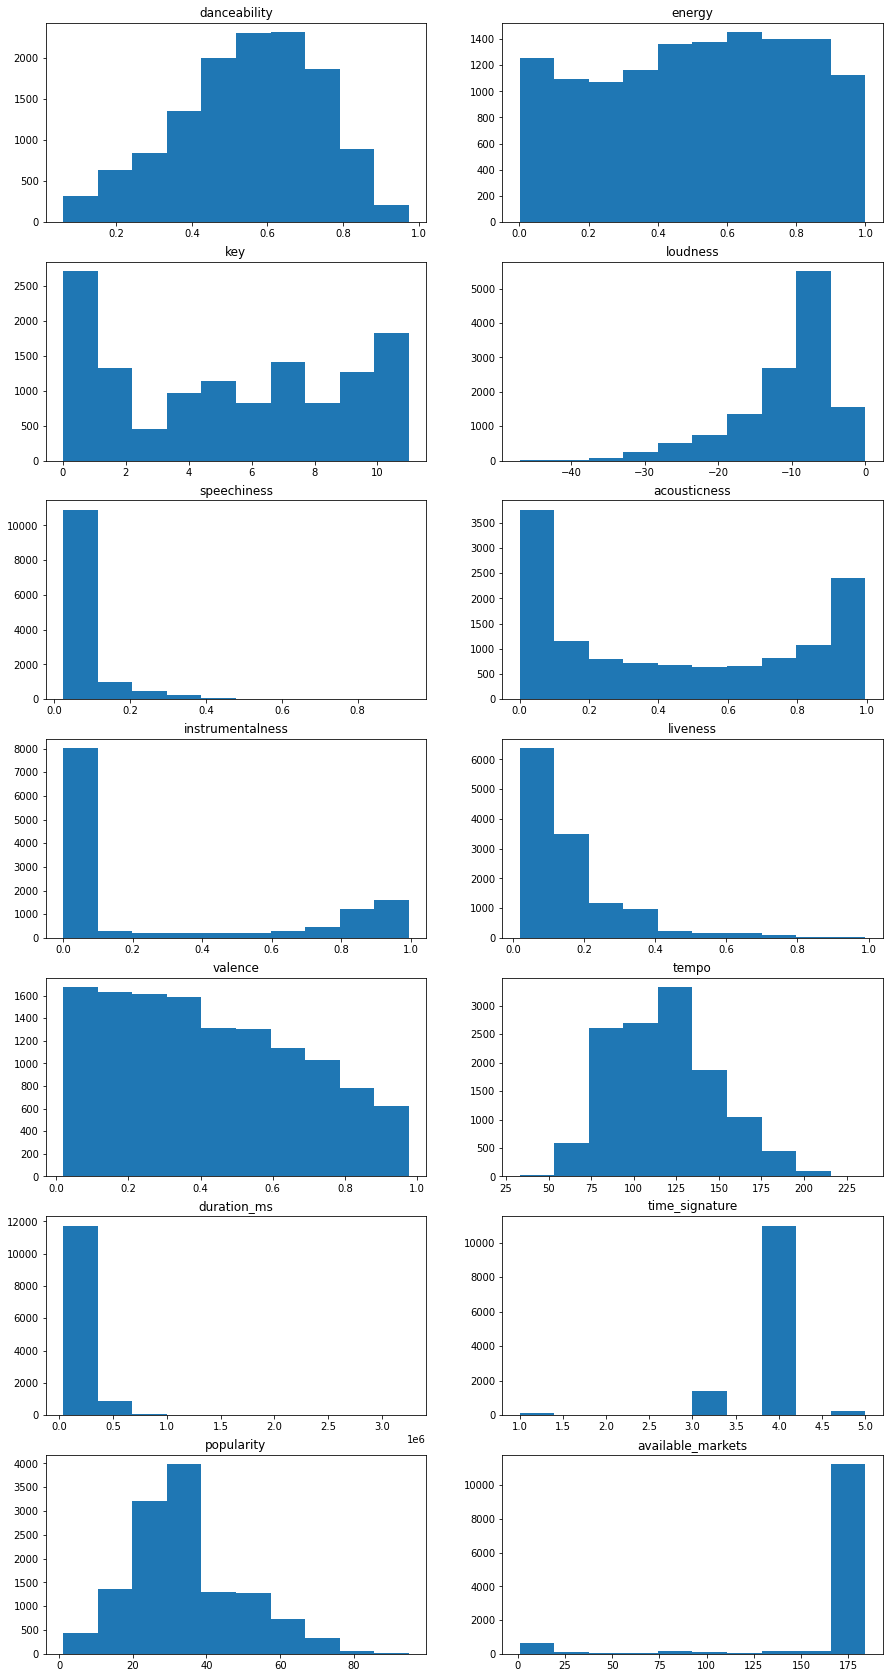

In [31]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12), (ax13, ax14)) = plt.subplots(7, 2,figsize=(15,30))
ax1.hist(df[['danceability']])
ax2.hist(df[['energy']])
ax3.hist(df[['key']])
ax4.hist(df[['loudness']])
ax5.hist(df[['speechiness']])
ax6.hist(df[['acousticness']])
ax7.hist(df[['instrumentalness']])
ax8.hist(df[['liveness']])
ax9.hist(df[['valence']])
ax10.hist(df[['tempo']])
ax11.hist(df[['duration_ms']])
ax12.hist(df[['time_signature']])
ax13.hist(df[['popularity_track']])
ax14.hist(df[['available_markets']])

ax1.title.set_text('danceability')
ax2.title.set_text('energy')
ax3.title.set_text('key')
ax4.title.set_text('loudness')
ax5.title.set_text('speechiness')
ax6.title.set_text('acousticness')
ax7.title.set_text('instrumentalness')
ax8.title.set_text('liveness')
ax9.title.set_text('valence')
ax10.title.set_text('tempo')
ax11.title.set_text('duration_ms')
ax12.title.set_text('time_signature')
ax13.title.set_text('popularity')
ax14.title.set_text('available_markets')

Text(0, 0.5, 'frequency')

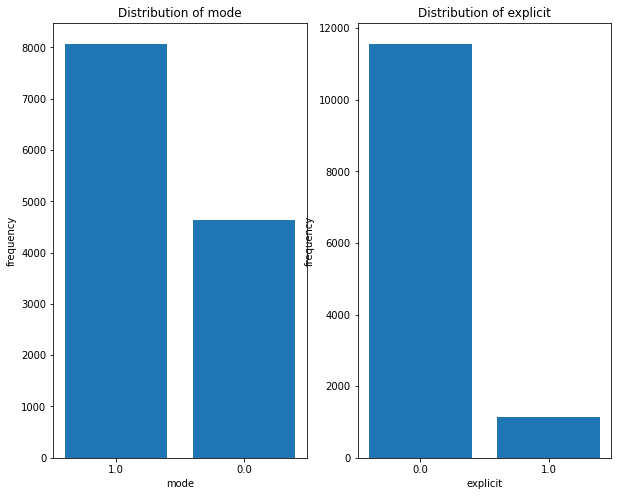

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
ax[0].bar(    
    x=list(map(str,df[catego_columns[0]].value_counts().keys().tolist())),
    height=df[catego_columns[0]].value_counts().values
    )
ax[0].set_title("Distribution of mode")
ax[0].set_xlabel("mode")
ax[0].set_ylabel("frequency")
ax[1].bar(    
    x=list(map(str,df[catego_columns[1]].value_counts().keys().tolist())),
    height=df[catego_columns[1]].value_counts().values
    )
ax[1].set_title("Distribution of explicit")
ax[1].set_xlabel("explicit")
ax[1].set_ylabel("frequency")

Text(0.5, 1.0, 'Popularity Based on Time Signature')

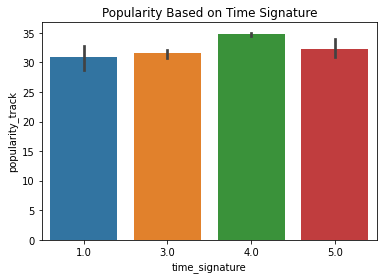

In [36]:
sns.barplot(x = 'time_signature', y = 'popularity_track', data = df)
plt.title('Popularity Based on Time Signature')

Text(0.5, 1.0, 'Popularity Based on Key')

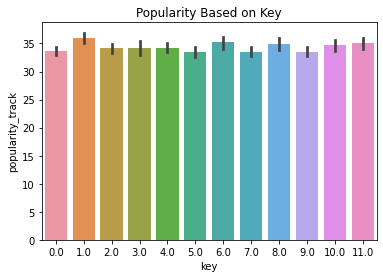

In [37]:
sns.barplot(x = 'key', y = 'popularity_track', data = df)
plt.title('Popularity Based on Key')

Text(0.5, 1.0, 'Popularity Based on Mode')

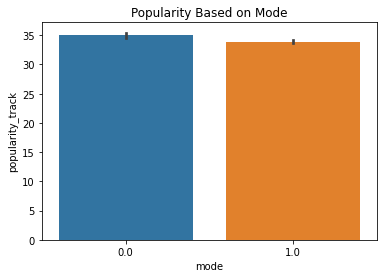

In [38]:
sns.barplot(x = 'mode', y = 'popularity_track', data = df)
plt.title('Popularity Based on Mode')

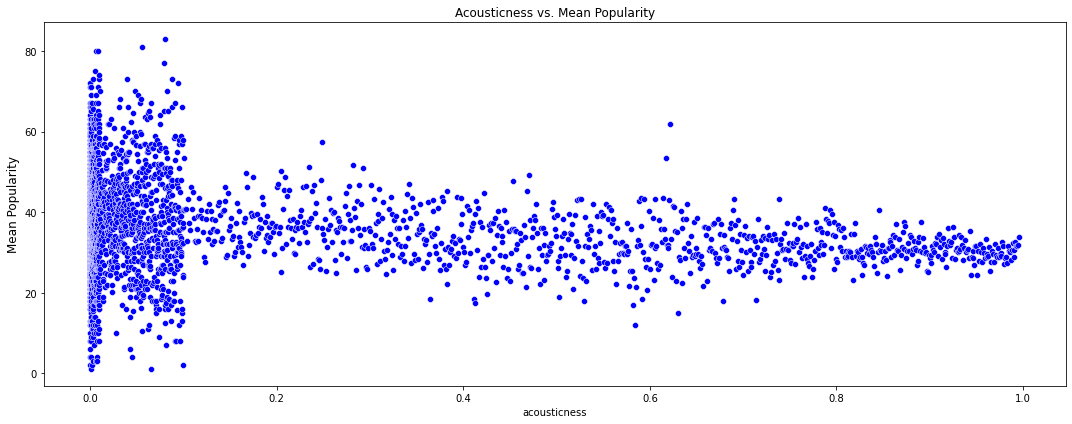

In [40]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('acousticness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x=ax1_data['acousticness'], y=ax1_data['popularity_track'], color='blue', ax=ax)
ax.set_title('Acousticness vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

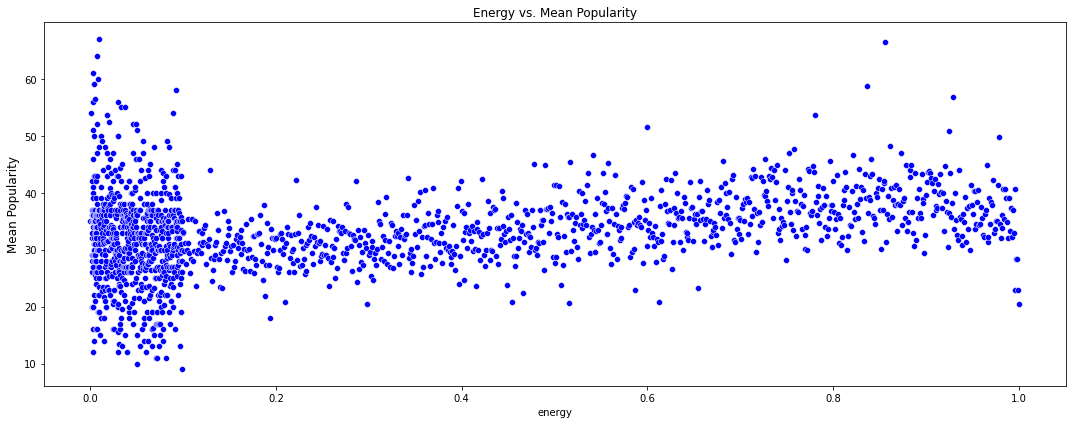

In [41]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('energy')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x=ax1_data['energy'], y=ax1_data['popularity_track'], color='blue', ax=ax)
ax.set_title('Energy vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

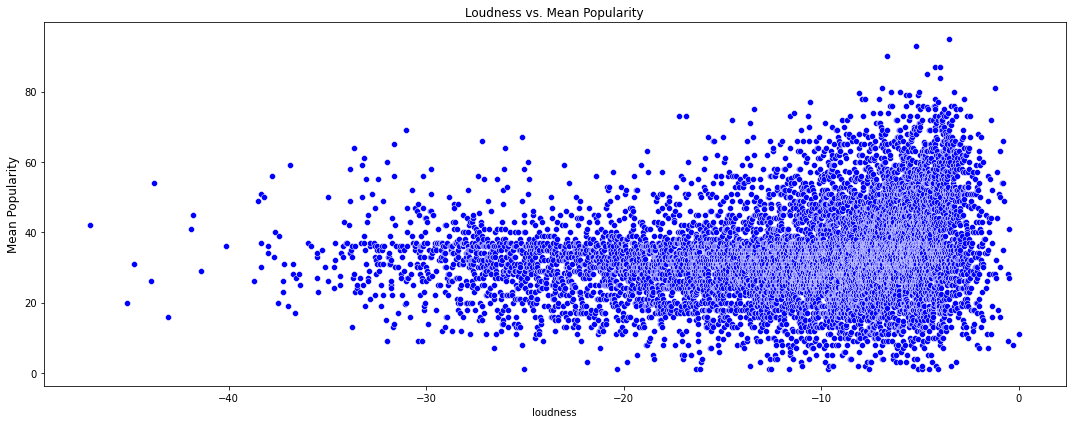

In [42]:
fig, ax = plt.subplots(figsize=(15, 6))
ax1_data =  df.groupby('loudness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x=ax1_data['loudness'], y=ax1_data['popularity_track'], color='blue', ax=ax)
ax.set_title('Loudness vs. Mean Popularity')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

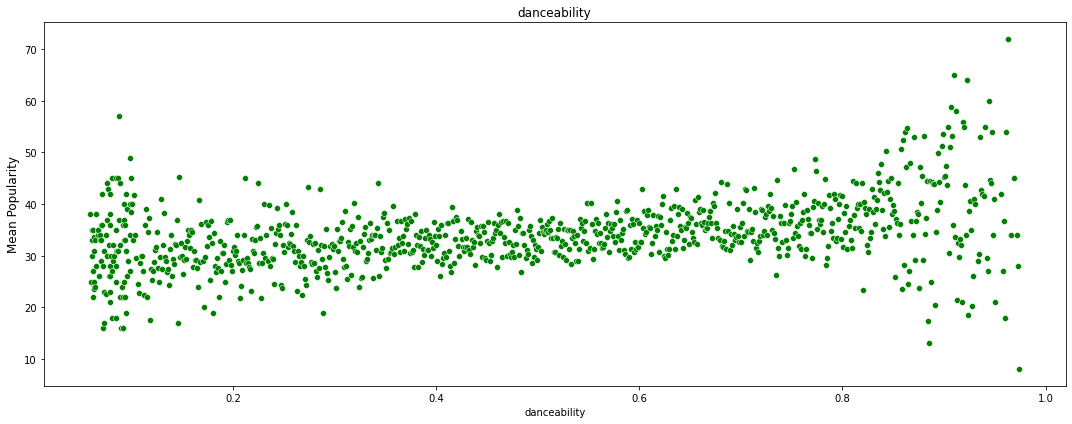

In [43]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('danceability')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='danceability', y='popularity_track', data=ax_data, color='green', ax=ax)
ax.set_title('danceability')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

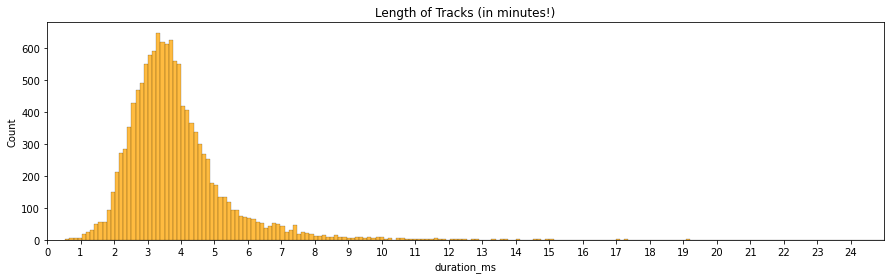

In [44]:
fig, ax = plt.subplots(figsize = (15, 4))
ax = sns.histplot(df['duration_ms']/60000, color='orange')
ax.set_title('Length of Tracks (in minutes!)')
ax.set_xticks(range(0,25,1))
ax.set_xlim(0,25)
plt.show()

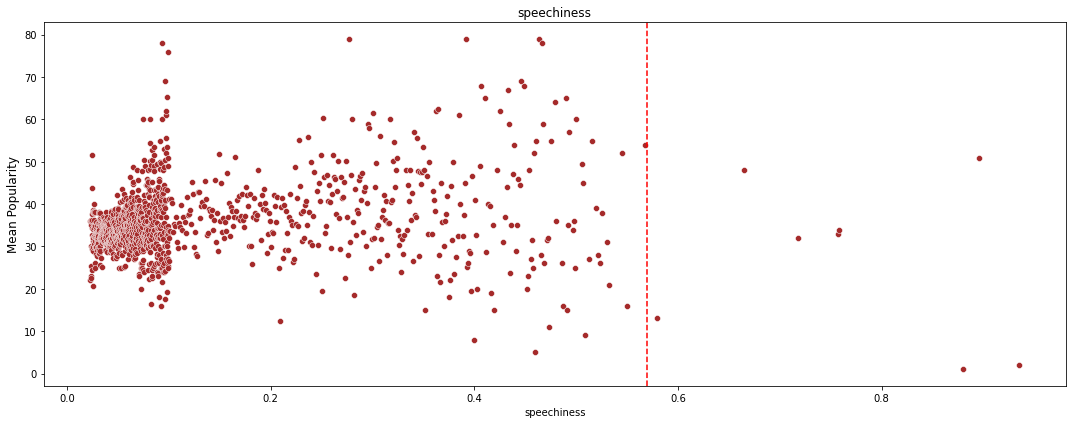

In [47]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('speechiness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='speechiness', y='popularity_track', data=ax_data, color='brown', ax=ax)
ax.axvline(x=0.57, ymin=0, ymax=1, color='red', linestyle='dashed')
ax.set_title('speechiness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

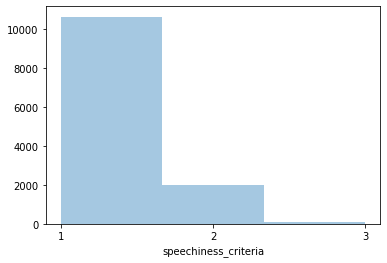

In [51]:
criteria= [df['speechiness'].between(0, 0.1),
           df['speechiness'].between(0.1000001, 0.40),
           df['speechiness'].between(0.400001, 1)]
values = [1, 2, 3]
df['speechiness_criteria'] = np.select(criteria, values, 0)
fig, ax = plt.subplots()
sns.distplot(df['speechiness_criteria'],ax=ax, kde=False, bins=3 )
ax.set_xticks(range(1,4))
plt.show()

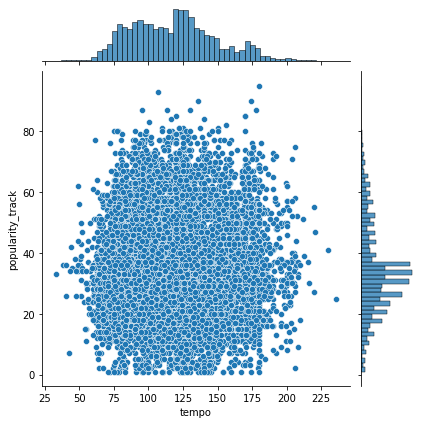

In [53]:
sns.jointplot(x='tempo', y='popularity_track', data=df)
plt.show()

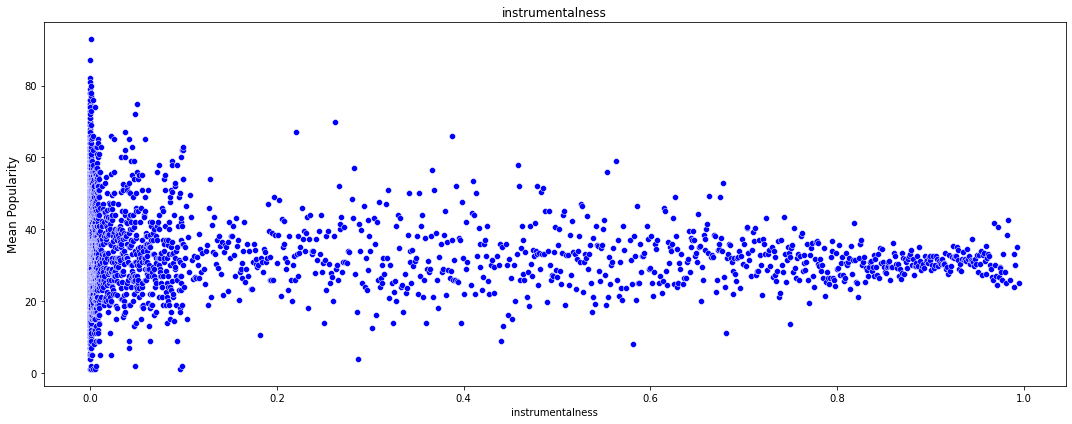

In [54]:
fig, ax = plt.subplots(1, figsize=(15, 6), sharey=True, sharex = True)
ax_data =  df.groupby('instrumentalness')['popularity_track'].mean().to_frame().reset_index()
ax = sns.scatterplot(x='instrumentalness', y='popularity_track', data=ax_data, color='blue', ax=ax)
ax.set_title('instrumentalness')
ax.set_ylabel('Mean Popularity', fontsize=12)
plt.tight_layout()
plt.show()

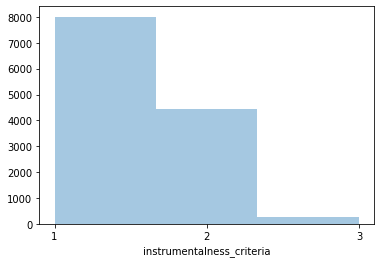

In [55]:
criteria= [df['instrumentalness'].between(0, 0.1),
           df['instrumentalness'].between(0.1000001, 0.95),
           df['instrumentalness'].between(0.950001, 1)]
values = [1, 2, 3]
df['instrumentalness_criteria'] = np.select(criteria, values, 0)
fig, ax = plt.subplots()
sns.distplot(df['instrumentalness_criteria'],ax=ax, kde=False, bins=3 )
ax.set_xticks(range(1,4))
plt.show()

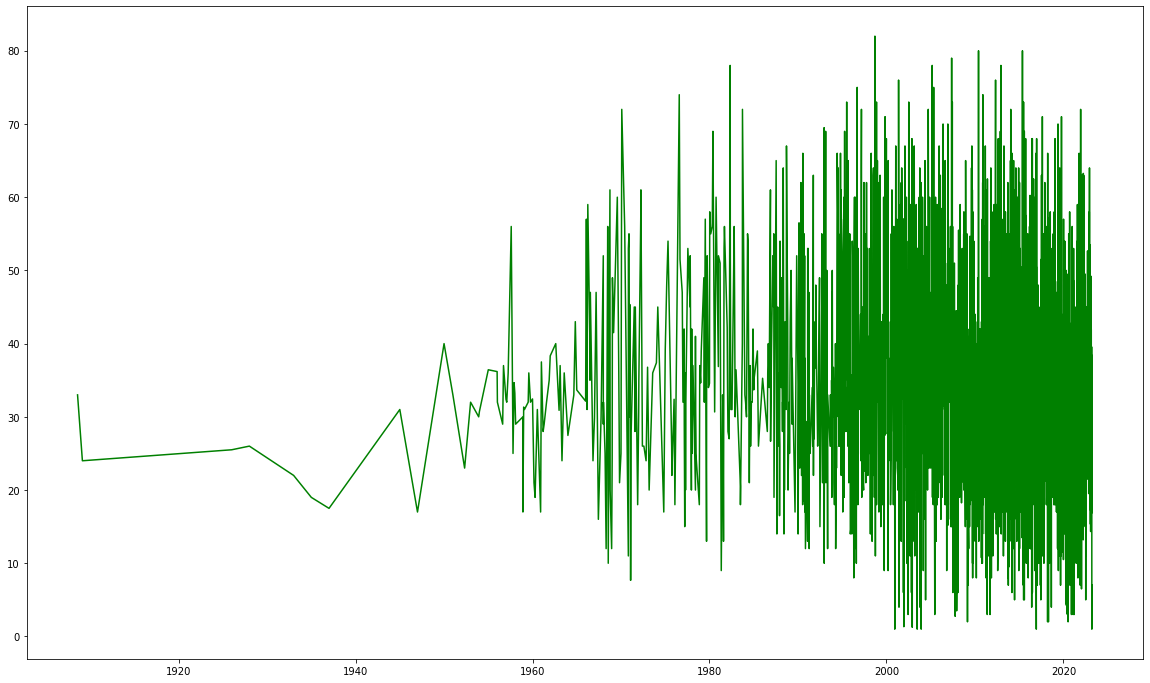

In [56]:
date_with_mean_pop = df.groupby('release_date')['popularity_track'].mean().to_frame().reset_index()
plt.figure(figsize=(20,12))
plt.plot_date(date_with_mean_pop[['release_date']],date_with_mean_pop[['popularity_track']], 'g')

## Correlation between features

<Axes: >

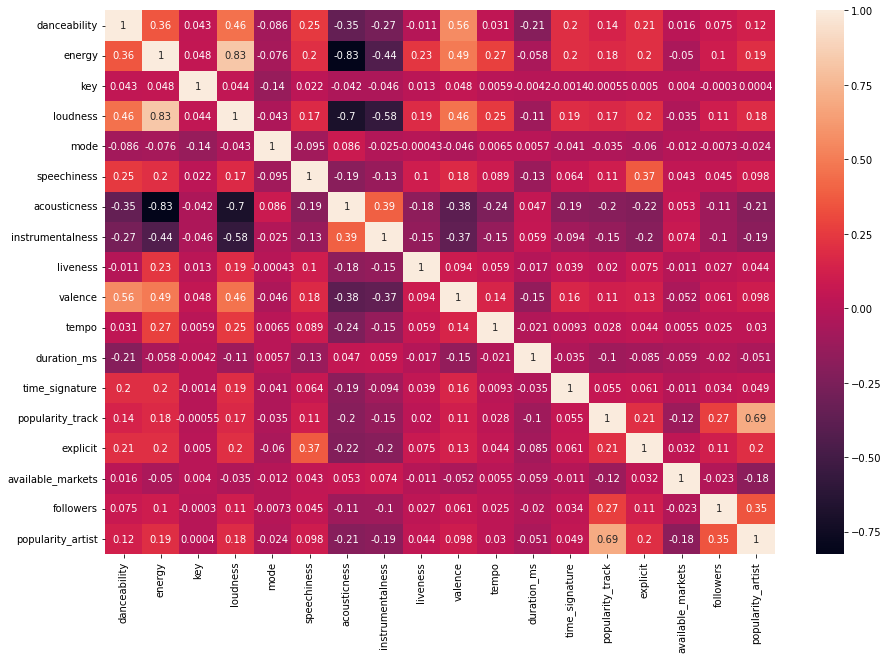

In [32]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)

# Model Buiding

In [33]:
df.head()

,id_album,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id_track,duration_ms,time_signature,name,artist_id,popularity_track,explicit,available_markets,followers,popularity_artist
0,73QdC5qhvKIf8NmoL6Foqt,2005-09-30,0.549,0.59500,5.0,-8.819,0.0,0.0300,0.377,0.0000,0.4330,0.4770,116.064,1dsXbmswZkEzI4x32yL5fD,320768.0,4.0,Dalam Gerimis,0NPzxa6Zh2dXlSiBX29rCE,36.0,0.0,184.0,1897.0,30.0
1,6O8BafrfHOLH6V2v3dsPV2,2016-04-05,0.510,0.33800,6.0,-9.371,1.0,0.0268,0.615,0.0000,0.1110,0.1410,147.939,5jUExRL4pCNDYPz9qzzK2F,249752.0,4.0,High and Dry,2Y4125mDrgQyPD7dt76Rtm,46.0,0.0,170.0,64770.0,50.0
2,4HsmQL9oNk7RPiD3sohwgk,2017-08-30,0.502,0.99900,3.0,-3.541,0.0,0.1010,0.132,0.0440,0.3750,0.2290,155.066,7A7c6stwWK2y1GTSYx43w9,68000.0,4.0,Stampuhh!! (The Prophet's Stamp Remix) - Mixed,5hnFqGY2kc233cXstqrGev;2iRqqPkOyIvvb7qFZN1Onz,23.0,0.0,181.0,60722.0,44.5
3,4ODaVW6oS0jRXMZKEkuJon,2017-08-30,0.161,0.00613,0.0,-38.027,1.0,0.0390,0.994,0.8460,0.0895,0.0363,74.671,7gpL5CorPuYBthvZkPPFGd,138798.0,1.0,Glitching,6vz9kIJB249V5DbMMH0WZA,34.0,0.0,184.0,995.0,54.0
4,6jvgwKo2bST4ih44ZRKyM3,2020-06-19,0.495,0.75000,9.0,-7.074,0.0,0.0431,0.447,0.0602,0.0863,0.8000,101.569,6Q10bO5VPryNqa61gclfS4,279848.0,4.0,A Donde Voy,2hQLLVGIGVE2XiQfXFTa8s,31.0,0.0,184.0,604.0,17.0


First, we need to split the data.

If we consider the usecase of Spotify, the company certainly wants to predict the popularity of future songs. Thus, we should split the dataset between songs issued before a certain year and songs issued after it.

We will make a train set of all the songs previous to 2022-11-04, and a test set composed of the songs issued on and after 2022-11-04 (20% of the total dataset).

In [31]:
X = df.sort_values(by='release_date').drop(columns=['popularity_track','id_album','id_track','artist_id','name']).copy()
y = df.sort_values(by='release_date')['popularity_track'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [32]:
X_train.tail(5)

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,available_markets,followers,popularity_artist
59666,2022-08-26,0.735,0.695,1.0,-6.589,0.0,0.0367,0.21700,0.011200,0.1210,0.557,104.986,261143.0,4.0,0.0,184.0,157.0,37.0
46616,2022-08-26,0.614,0.353,6.0,-7.662,1.0,0.0307,0.79700,0.000000,0.1110,0.193,105.907,237900.0,4.0,0.0,184.0,26885.0,44.0
38833,2022-08-26,0.488,0.175,8.0,-9.500,1.0,0.0491,0.95200,0.000001,0.1050,0.201,117.291,201542.0,4.0,0.0,183.0,123395.0,65.0
38834,2022-08-26,0.536,0.605,7.0,-5.292,1.0,0.0338,0.14100,0.000000,0.0614,0.341,130.053,196163.0,4.0,0.0,183.0,123395.0,65.0
70136,2022-08-26,0.556,0.865,6.0,-2.982,0.0,0.0658,0.00341,0.000000,0.2430,0.432,91.045,191560.0,4.0,0.0,184.0,1079940.0,64.0


In [33]:
X_train['release_date']=X_train['release_date'].map(dt.datetime.toordinal)
X_test['release_date']=X_test['release_date'].map(dt.datetime.toordinal)

In [40]:
X_train

,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,explicit,available_markets,followers,popularity_artist
15415,696730,0.639,0.380,0.0,-16.251,1.0,0.0753,0.4260,0.000584,0.1240,0.488,97.814,280573.0,1.0,0.0,184.0,602.0,21.0
17588,696930,0.356,0.263,5.0,-8.239,1.0,0.0308,0.7920,0.006120,0.1780,0.374,73.827,187573.0,4.0,0.0,1.0,85161.0,53.0
16267,703092,0.749,0.218,5.0,-8.931,0.0,0.0820,0.9860,0.842000,0.7540,0.693,113.410,180000.0,4.0,0.0,184.0,142.0,9.0
18056,703092,0.731,0.179,5.0,-17.177,1.0,0.0634,0.9120,0.007520,0.1110,0.789,154.709,158427.0,4.0,0.0,183.0,118604.0,47.0
17612,703822,0.683,0.285,3.0,-12.101,1.0,0.0366,0.9940,0.603000,0.1220,0.783,94.913,175400.0,4.0,0.0,114.0,9879.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14262,738463,0.749,0.630,4.0,-6.652,0.0,0.1160,0.0623,0.000000,0.3530,0.445,122.030,242027.0,4.0,1.0,183.0,73459547.0,97.0
4738,738463,0.663,0.802,2.0,-5.126,0.0,0.0381,0.0050,0.041900,0.6170,0.307,125.989,177143.0,4.0,0.0,183.0,63351.0,58.5
12445,738463,0.657,0.355,4.0,-19.181,0.0,0.0282,0.7260,0.936000,0.0829,0.814,108.015,188000.0,4.0,0.0,184.0,5888.0,29.0
1352,738463,0.326,0.324,0.0,-11.476,0.0,0.0365,0.9500,0.920000,0.1220,0.269,91.852,163945.0,3.0,0.0,184.0,306.0,27.0


In [34]:
ct = ColumnTransformer([('minmax', MinMaxScaler(), ['release_date','loudness', 'tempo', 'duration_ms','available_markets','followers','popularity_artist']),
                        ('categorical', OneHotEncoder(), ['key','mode','time_signature','explicit']),
                       ],
                       remainder='passthrough')

ct.fit(X_train)

X_train_preprocessed = pd.DataFrame(ct.transform(X_train).tolist())
X_test_preprocessed = pd.DataFrame(ct.transform(X_test).tolist())

In [36]:
#Output all features for prediction use
pd.DataFrame(ct.get_feature_names_out()).to_csv("Popularity_features.csv", index=False)

In [37]:
X_test_preprocessed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,1.000000,0.909911,0.716795,0.061905,0.994536,6.134873e-05,0.581633,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.276,0.783,0.0626,0.038100,0.00000,0.0697,0.156
1,1.000000,0.822715,0.493338,0.049528,0.994536,2.600457e-05,0.306122,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.799,0.354,0.0401,0.412000,0.00114,0.1130,0.455
2,1.000000,0.664213,0.264580,0.034317,0.994536,8.607972e-06,0.397959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.802,0.275,0.1870,0.821000,0.69100,0.1130,0.252
3,1.000000,0.720649,0.848295,0.027387,1.000000,6.503399e-07,0.234694,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.467,0.156,0.0448,0.430000,0.77800,0.1010,0.365
4,1.000000,0.573656,0.496253,0.023674,1.000000,1.533718e-05,0.469388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.389,0.177,0.0346,0.897000,0.95100,0.1130,0.130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2537,1.003187,0.686081,0.437591,0.075343,1.000000,9.714453e-06,0.142857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.484,0.343,0.0456,0.917000,0.33400,0.1300,0.404
2538,1.003187,0.567572,0.394771,0.099867,0.000000,2.850657e-05,0.170068,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.495,0.217,0.0320,0.994000,0.86800,0.1100,0.403
2539,1.003187,0.928163,0.754491,0.059690,0.715847,8.538241e-04,0.520408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.311,0.934,0.0880,0.000092,0.00106,0.3660,0.169
2540,1.003211,0.806356,0.569249,0.051585,0.994536,2.146423e-05,0.217687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.628,0.805,0.0380,0.083000,0.00000,0.2730,0.688


In [37]:
def instrumentalness_criteria(X):
    X.iloc[:,30] = list(map((lambda x: 1 if x < 0.1 else (3 if x > 0.4 else 2)), X.iloc[:,30]))

instrumentalness_tranformer = FunctionTransformer(instrumentalness_criteria)
instrumentalness_tranformer.transform(X_train_preprocessed)
instrumentalness_tranformer.transform(X_test_preprocessed)

In [38]:
def speechiness_criteria(X):
    X.iloc[:,28] = list(map((lambda x: 1 if x < 0.1 else (3 if x > 0.95 else 2)), X.iloc[:,28]))

speechiness_tranformer = FunctionTransformer(speechiness_criteria)
speechiness_tranformer.transform(X_train_preprocessed)
speechiness_tranformer.transform(X_test_preprocessed)

In [39]:
y_train = y_train / 100
y_test = y_test/100
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [40]:
# verifictaion
nl = '\n'
print(f'X_train_preprocessed shape is: {X_train_preprocessed.shape} {nl}y_train shape is: {y_train.shape} {nl}X_test_preprocessed shape is: {X_test_preprocessed.shape} {nl}y_test shape is: {y_test.shape}')

X_train_preprocessed shape is: (69328, 35) 
y_train shape is: (69328,) 
X_test_preprocessed shape is: (17332, 35) 
y_test shape is: (17332,)


### Linear Regression (selected features only (corr > 0.2))

In [67]:
X_train_preprocessed.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
0,0.000000,0.654130,0.329676,0.077051,1.0,0.000005,0.214286,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.639,2,0.0753,3,0.000584,0.124,0.488
1,0.004792,0.824566,0.207878,0.048152,0.0,0.000769,0.540816,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.356,2,0.0308,3,0.006120,0.178,0.374
2,0.152445,0.809845,0.408867,0.045799,1.0,0.000001,0.091837,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.749,2,0.0820,3,0.842000,0.754,0.693


In [68]:
X_train_preprocessed.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33
count,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.000000,10168.00000,10168.000000,10168.000000,10168.000000,10168.000000
mean,0.911334,0.765223,0.426983,0.064005,0.896108,0.005020,0.414335,0.123230,0.086153,0.105527,0.036192,0.077695,0.090972,0.061664,0.111035,0.063139,0.102478,0.068352,0.073564,0.357691,0.642309,0.010818,0.115559,0.855921,0.017703,0.927223,0.072777,0.540574,1.930566,0.06958,2.224528,0.283624,0.171531,0.420935
std,0.120395,0.144953,0.154822,0.034288,0.263914,0.028269,0.178535,0.328717,0.280603,0.307247,0.186777,0.267704,0.287583,0.240556,0.314190,0.243225,0.303291,0.252361,0.261073,0.479344,0.479344,0.103452,0.319711,0.351188,0.131875,0.259783,0.259783,0.188930,0.377515,0.07016,0.862677,0.386094,0.138615,0.262246
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.059500,1.000000,0.02280,1.000000,0.000000,0.018800,0.018900
25%,0.870247,0.699148,0.304982,0.045799,0.978142,0.000016,0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.415000,2.000000,0.03500,1.000000,0.000003,0.095900,0.196000
50%,0.965279,0.809813,0.426412,0.058214,0.994536,0.000182,0.408163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.556000,2.000000,0.04400,3.000000,0.003385,0.116000,0.390000
75%,0.992117,0.870099,0.523084,0.073449,1.000000,0.001405,0.540816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.683000,2.000000,0.06740,3.000000,0.754000,0.192000,0.628000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.974000,3.000000,0.93500,3.000000,0.995000,0.991000,0.977000


In [41]:
LR = LinearRegression()
cols = [col for col in X_train_preprocessed.columns if abs(X_train_preprocessed[col].corr(y_train))>0.1]

# Fit the model and
LR.fit(X_train_preprocessed.drop(columns=cols), y_train)

# Train Predicting with the model
y_train_pred = LR.predict(X_train_preprocessed.drop(columns=cols)).clip(0, 1)

# RMSE Train
LR_rmse = np.sqrt(mse(y_train, y_train_pred))
print(f"RMSE Train = {LR_rmse:.5f}")

RMSE Train = 0.16834


In [42]:
#Predicting with the model
y_test_pred = LR.predict(X_test_preprocessed.drop(columns=cols)).clip(0, 1)

# RMSE Test
LR_rmse = np.sqrt(mse(y_test, y_test_pred))
print(f"RMSE Val = {LR_rmse:.5f}")

RMSE Val = 0.16600


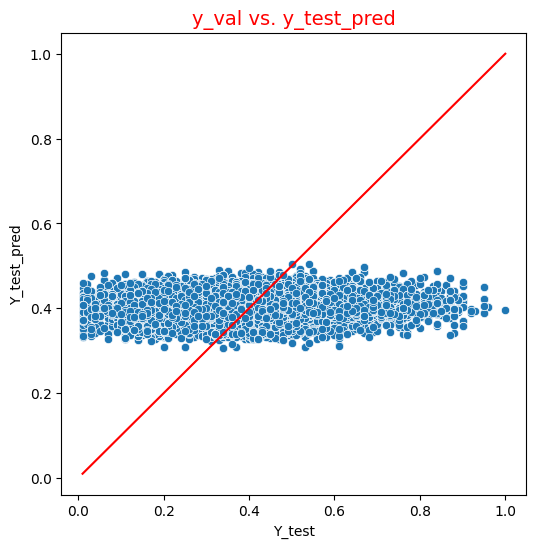

In [43]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_val vs. y_test_pred', fontsize=14, color='red')
plt.show()

### Linear Regression (all features)

In [44]:
LR = LinearRegression()

# Fit the model and
LR.fit(X_train_preprocessed, y_train)

# Train Predicting with the model
y_train_pred2 = LR.predict(X_train_preprocessed).clip(0, 1)

# RMSE Train
LR_rmse2 = np.sqrt(mse(y_train, y_train_pred2))
print(f"RMSE Train = {LR_rmse2:.6f}")

RMSE Train = 0.122263


In [45]:
#Predicting with the model
y_test_pred = LR.predict(X_test_preprocessed).clip(0, 1)

# RMSE Test
LR_rmse2 = np.sqrt(mse(y_test, y_test_pred))
print(f"RMSE Test = {LR_rmse2:.6f}")

RMSE Test = 0.105951


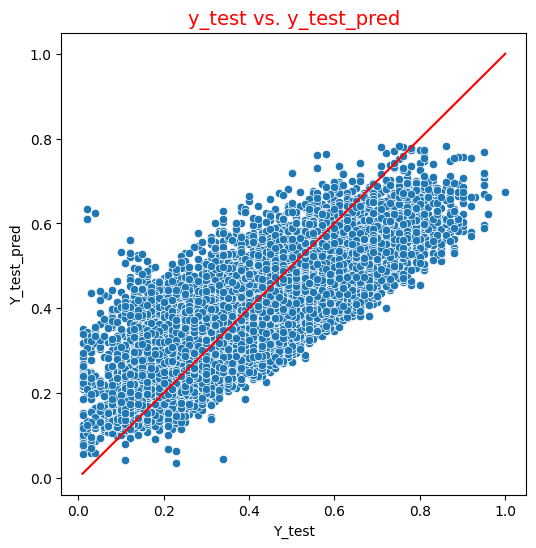

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [47]:
model = sm.OLS(list(y_train), X_train_preprocessed).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     2105.
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:03:00   Log-Likelihood:                 47319.
No. Observations:               69328   AIC:                        -9.457e+04
Df Residuals:                   69296   BIC:                        -9.428e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0136      0.004      3.072      0.002       0.005       0.022
1              0.0372      0.006      5.845      0.000       0.025       0.050
2              0.0040      0.004      1.113      0.266      -0.003       0.011
3             -0.5960      0.016    -36.590      0.000      -0.628      -0.564
4              0.0240      0.002      9.733      0.000       0.019       0.029
5              0.1148      0.007     15.479      0.000       0.100       0.129
6              0.5443      0.003    194.742      0.000       0.539       0.550
7              0.0128      0.002      8.179      0.000       0.010       0.016
8              0.0160      0.002      9.400      0.000       0.013       0.019
9              0.0121      0.002      7.426      0.000       0.009       0.015
10             0.0144      0.002      6.006      0.000       0.010       0.019
11             0.0134      0.002      7.444      0.000       0.010       0.017
12             0.0077      0.002      4.512      0.000       0.004       0.011
13             0.0144      0.002      7.479      0.000       0.011       0.018
14             0.0086      0.002      5.361      0.000       0.005       0.012
15             0.0124      0.002      6.443      0.000       0.009       0.016
16             0.0126      0.002      7.524      0.000       0.009       0.016
17             0.0069      0.002      3.658      0.000       0.003       0.011
18             0.0138      0.002      7.434      0.000       0.010       0.017
19             0.0739      0.005     14.750      0.000       0.064       0.084
20             0.0710      0.005     14.227      0.000       0.061       0.081
21             0.0603      0.034      1.776      0.076      -0.006       0.127
22             0.0226      0.008      2.801      0.005       0.007       0.038
23             0.0178      0.007      2.427      0.015       0.003       0.032
24             0.0232      0.007      3.189      0.001       0.009       0.037
25             0.0211      0.008      2.712      0.007       0.006       0.036
26             0.0491      0.005      9.926      0.000       0.039       0.059
27             0.0959      0.005     18.544      0.000       0.086       0.106
28            -0.0134      0.004     -3.352      0.001      -0.021      -0.006
29            -0.0391      0.004     -9.611      0.000      -0.047      -0.031
30            -0.0158      0.001    -12.490      0.000      -0.018      -0.013
31            -0.0328      0.002    -13.936      0.000      -0.037      -0.028
32             0.0062      0.002      3.689      0.000       0.003       0.010
33            -0.0465      0.003    -13.361      0.000      -0.053      -0.040
34             0.0250      0.002     11.063      0.000       0.021       0.029
==============================================================================
Om

In [48]:
r2_lr = r2_score(y_test, y_test_pred)
print("{:.6f}".format(round(r2_lr, 6)))

0.597741


### Lasso

In [49]:
# Lasso
lasso=Lasso()

lasso_fit = lasso.fit(X_train_preprocessed,y_train)

y_pred = lasso.predict(X_test_preprocessed)

mean_squared_error(y_test, y_pred, squared=False)

0.16705671492950017

In [50]:
# RMSE Test
LR_rmse3 = np.sqrt(mse(y_test, y_pred))
print(f"RMSE Test = {LR_rmse3:.6f}")

RMSE Test = 0.167057


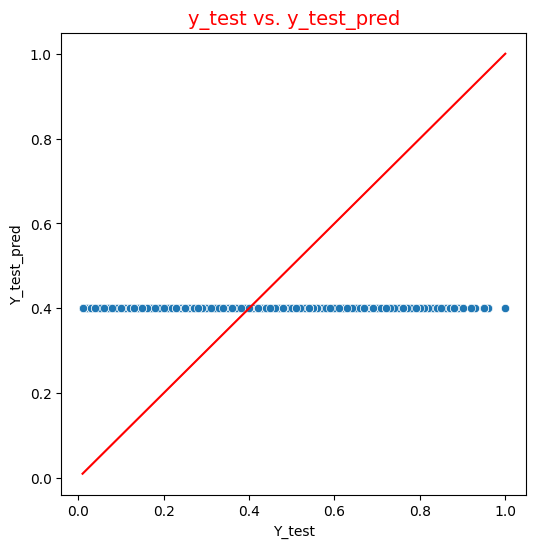

In [51]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [52]:
r2_lasso = r2_score(y_test, y_pred)
print("{:.6f}".format(round(r2_lasso, 6)))

-0.000060


### XGBoost Regression

In [62]:
# XGBoost regressor
xgb_regressor = XGBRegressor(n_estimators=100, max_depth=20, learning_rate=0.01)

xgb_fit = xgb_regressor.fit(X_train_preprocessed, y_train)

y_pred_xg = xgb_regressor.predict(X_test_preprocessed)

mean_squared_error(y_test, y_pred_xg, squared=False)

0.12110424439175725

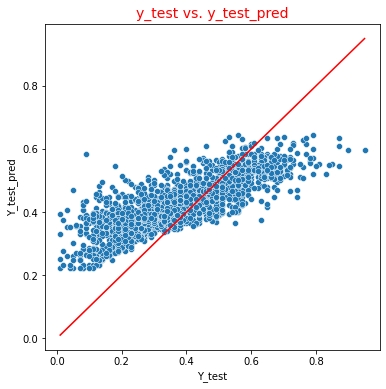

In [67]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_pred_xg)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [72]:
r2_xg = r2_score(y_test, y_pred_xg)
print("{:.6f}".format(round(r2_xg, 6)))

0.350465


### K-Nearest-Neighbors (KNN) Regression

In [75]:
# K-Nearest-Neighbors (KNN) regressor
neigh = KNeighborsRegressor(n_neighbors=7)

neigh_fit = neigh.fit(X_train_preprocessed, y_train)

y_pred_kn=neigh.predict(X_test_preprocessed)

mean_squared_error(y_test, y_pred_kn, squared=False)

0.12515765038872423

In [76]:
r2_kn = r2_score(y_test, y_pred_kn)
print("{:.6f}".format(round(r2_kn, 6)))

0.306257


### Polynomial

In [53]:
poly = PolynomialFeatures(2)
X_poly = poly.fit_transform(X_train_preprocessed)
pol_reg = LinearRegression()
model_log = sm.OLS(y_train, X_poly).fit()

In [54]:
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       popularity_track   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     187.3
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        22:03:39   Log-Likelihood:                 51117.
No. Observations:               69328   AIC:                        -1.014e+05
Df Residuals:                   68898   BIC:                        -9.744e+04
Df Model:                         429                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.451e+09   5.62e+09      0.436      0.663   -8.56e+09    1.35e+10
x1          3.169e+08   7.26e+08      0.436      0.663   -1.11e+09    1.74e+09
x2           9.78e+07   2.24e+08      0.436      0.663   -3.41e+08    5.37e+08
x3          9.481e+07   2.17e+08      0.436      0.663   -3.31e+08    5.21e+08
x4         -1.616e+08    3.7e+08     -0.436      0.663   -8.87e+08    5.64e+08
x5         -2.355e+09    5.4e+09     -0.436      0.663   -1.29e+10    8.22e+09
x6          8.458e+07   1.94e+08      0.436      0.663   -2.95e+08    4.64e+08
x7          1.679e+08   3.85e+08      0.436      0.663   -5.86e+08    9.22e+08
x8          5.407e+08   1.24e+09      0.436      0.663   -1.89e+09    2.97e+09
x9          2.241e+08   5.13e+08      0.436      0.663   -7.82e+08    1.23e+09
x10          5.04e+07   1.15e+08      0.436      0.663   -1.76e+08    2.77e+08
x11         1.417e+08   3.25e+08      0.436      0.663   -4.95e+08    7.78e+08
x12         2.342e+08   5.37e+08      0.436      0.663   -8.18e+08    1.29e+09
x13         2.167e+08   4.96e+08      0.436      0.663   -7.56e+08    1.19e+09
x14         5.917e+07   1.36e+08      0.436      0.663   -2.07e+08    3.25e+08
x15         1.543e+08   3.54e+08      0.436      0.663   -5.39e+08    8.48e+08
x16         3.203e+07   7.34e+07      0.436      0.663   -1.12e+08    1.76e+08
x17         2.674e+08   6.13e+08      0.436      0.663   -9.34e+08    1.47e+09
x18        -1.174e+08   2.69e+08     -0.436      0.663   -6.45e+08     4.1e+08
x19        -2.575e+07    5.9e+07     -0.436      0.663   -1.41e+08    8.99e+07
x20        -1.264e+08    2.9e+08     -0.436      0.663   -6.94e+08    4.41e+08
x21        -1.992e+09   4.56e+09     -0.436      0.663   -1.09e+10    6.95e+09
x22        -3.664e+07    8.4e+07     -0.436      0.663   -2.01e+08    1.28e+08
x23        -2.804e+08   6.43e+08     -0.436      0.663   -1.54e+09    9.79e+08
x24        -2.274e+08   5.21e+08     -0.436      0.663   -1.25e+09    7.94e+08
x25        -3.069e+09   7.03e+09     -0.436      0.663   -1.69e+10    1.07e+10
x26        -2.082e+08   4.77e+08     -0.436      0.663   -1.14e+09    7.27e+08
x27         -3.12e+09   7.15e+09     -0.436      0.663   -1.71e+10    1.09e+10
x28        -7.014e+08   1.61e+09     -0.436      0.663   -3.85e+09    2.45e+09
x29        -7.391e+09   1.69e+10     -0.436      0.663   -4.06e+10    2.58e+10
x30         4.695e+07   1.08e+08      0.436      0.663   -1.64e+08    2.58e+08
x31        -3.425e+09   7.85e+09     -0.436      0.663   -1.88e+10     1.2e+10
x32        -1.581e+08   3.62e+08     -0.436      0.663   -8.68e+08    5.52e+08
x33        -9.037e+07   2.07e+08     -0.436      0.663   -4.96e+08    3.16e+08
x34         1.041e+08   2.39e+08      0.436      0.663   -3.64e+08    5.72e+08
x35        -1.796e+08   4.12e+08     -0.436      0.663   -9.86e+08    6.27e+08
x3

In [55]:
X_poly_test = poly.transform(X_test_preprocessed)
y_test_pred = model_log.predict(X_poly_test)

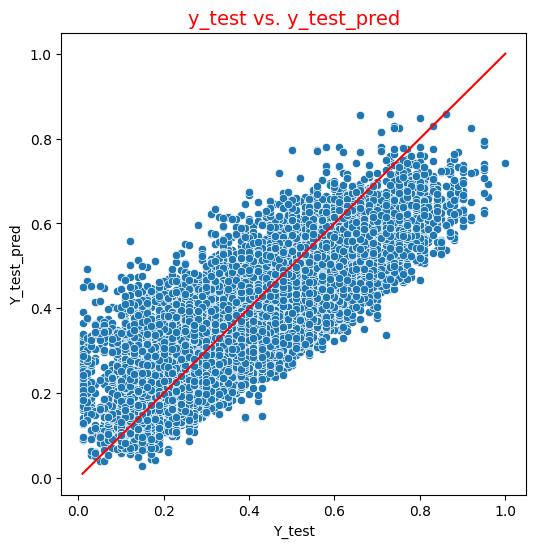

In [56]:
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.scatterplot(x=y_test, y=y_test_pred)
sns.lineplot(x=y_test, y=y_test, color='red', ax=ax)
ax.set_xlabel('Y_test')
ax.set_ylabel('Y_test_pred')
ax.set_title('y_test vs. y_test_pred', fontsize=14, color='red')
plt.show()

In [57]:
r2_poly = r2_score(y_test, y_test_pred)

## Model Comparison

Comparing Linear, Lasso, Polinomial, XGboost, KNN, the adjusted R-squared of linear regression is the highest. We may use linear regression for the final model.

In [59]:
r2 = [r2_lr,r2_lasso,r2_xg,r2_kn,r2_poly]
name = ['Linear Regression','Lasso Regression','XGboost Regression','K-Nearest-Neighbors Regression','Polynomial Regresson']
r2_df = pd.DataFrame([name,r2]).T
r2_df.columns = ['Method','R2 Score']
r2_df

,Method,R2 Score
0,Linear Regression,0.597741
1,Lasso Regression,-0.00006
2,XGboost Regression,0.350465
3,K-Nearest-Neighbors Regression,0.306257
4,Polynomial Regresson,0.594139


In [61]:
# export model
joblib.dump(LR, 'Popularity_Prediction_Model.sav')

['Popularity_Prediction_Model.sav']